#### **Importing Packages**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

#### **Reading in Datasets**

In [2]:
customers = pd.read_csv("../../data/processed/customer.csv")
digital_usage = pd.read_csv("../../data/processed/digital_usage.csv")
loans = pd.read_csv("../../data/processed/loans.csv")
products = pd.read_csv("../../data/processed/products_owned.csv")
transactions = pd.read_csv("../../data/processed/transactions.csv")
segments = pd.read_csv("../../customer_segmentation/customer_segments.csv")

#### **Data Inspection & Preparation**

##### Customers Dataset

In [3]:
# Merging segments and customers datasets
df = pd.merge(segments, customers, on = 'customer_id')

In [4]:
print("Dimensions:", df.shape)
df.head()

Dimensions: (4000, 14)


,customer_id,Segment,age,job,marital,education,default,balance,debt,income,tenure,nps,dependents,customer_lifetime_value
0,217,Budget-conscious,33,unemployed,single,primary,1,-23869.04,15283.08,277.46,26,10,1,243.87
1,179,Budget-conscious,32,retired,single,secondary,1,-16434.66,12630.49,716.15,24,9,3,259.91
2,81,At risk / inactive customers,20,unemployed,single,secondary,1,-11910.44,21609.58,539.38,10,8,3,224.93
3,50,At risk / inactive customers,35,unemployed,single,tertiary,1,-10332.25,47532.55,269.77,27,0,3,355.19
4,13,Budget-conscious,35,student,single,secondary,1,-8003.47,36324.75,522.33,27,9,1,299.71


In [5]:
print("DataFrame Structure:")
df.info()

DataFrame Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              4000 non-null   int64  
 1   Segment                  4000 non-null   object 
 2   age                      4000 non-null   int64  
 3   job                      4000 non-null   object 
 4   marital                  4000 non-null   object 
 5   education                4000 non-null   object 
 6   default                  4000 non-null   int64  
 7   balance                  4000 non-null   float64
 8   debt                     4000 non-null   float64
 9   income                   4000 non-null   float64
 10  tenure                   4000 non-null   int64  
 11  nps                      4000 non-null   int64  
 12  dependents               4000 non-null   int64  
 13  customer_lifetime_value  4000 non-null   float64
dtypes: 

In [6]:
print("Descriptive Statistics:")
print(df.drop('customer_id', axis=1).describe())
df.head()

Descriptive Statistics:
               age      default        balance           debt        income  \
count  4000.000000  4000.000000    4000.000000    4000.000000   4000.000000   
mean     39.802000     0.161250    1955.631387   25536.410247   4926.078810   
std      10.342608     0.367807    7637.884812   24517.833775   3288.695279   
min      18.000000     0.000000  -23869.040000    1007.770000    200.470000   
25%      32.000000     0.000000      70.605000   10315.447500   2692.537500   
50%      39.000000     0.000000     354.820000   18392.535000   4082.075000   
75%      47.000000     0.000000    1392.977500   32017.870000   6256.390000   
max      77.000000     1.000000  202759.360000  421994.640000  31448.860000   

            tenure          nps   dependents  customer_lifetime_value  
count  4000.000000  4000.000000  4000.000000              4000.000000  
mean     32.335750     6.888500     2.339500               730.801637  
std       7.992965     3.443767     1.299485    

,customer_id,Segment,age,job,marital,education,default,balance,debt,income,tenure,nps,dependents,customer_lifetime_value
0,217,Budget-conscious,33,unemployed,single,primary,1,-23869.04,15283.08,277.46,26,10,1,243.87
1,179,Budget-conscious,32,retired,single,secondary,1,-16434.66,12630.49,716.15,24,9,3,259.91
2,81,At risk / inactive customers,20,unemployed,single,secondary,1,-11910.44,21609.58,539.38,10,8,3,224.93
3,50,At risk / inactive customers,35,unemployed,single,tertiary,1,-10332.25,47532.55,269.77,27,0,3,355.19
4,13,Budget-conscious,35,student,single,secondary,1,-8003.47,36324.75,522.33,27,9,1,299.71


In [7]:
# Converting 'job', 'marital', and 'education' columns to category data type
categorical_columns = ['job', 'marital', 'education']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Creating 'nps_category' column that segments responses into promoters, passives, and detractors
nps_bins = [-float('inf'), 6, 8, 10]
nps_labels = ['detractor', 'passive', 'promoter']
df['nps_category'] = pd.cut(df['nps'], bins=nps_bins, labels=nps_labels)

# Dropping the original 'nps' column
df.drop(['nps'], axis=1, inplace=True)

# Applying log transformation to 'balance', 'debt', and 'income' to scale and stabilize the values
df['log_balance'] = np.sign(df['balance']) * np.log1p(np.abs(df['balance']))
df['log_debt'] = np.log1p(df['debt'])
df['log_income'] = np.log1p(df['income'])

# Creating 'debt-to-income' ratio and 'balance-to-debt' ratio columns
df['debt_to_income'] = df['log_debt'] / df['log_income']
df['balance_to_debt'] = df['log_balance'] / df['log_debt']

In [8]:
print(df[['log_balance', 'log_debt', 'log_income', 'debt_to_income', 'balance_to_debt']].describe())

       log_balance     log_debt   log_income  debt_to_income  balance_to_debt
count  4000.000000  4000.000000  4000.000000     4000.000000      4000.000000
mean      4.487013     9.809940     8.308531        1.187905         0.463488
std       4.534018     0.829908     0.633496        0.139580         0.463366
min     -10.080379     6.916487     5.305640        0.788346        -1.046272
25%       4.271165     9.241495     7.898611        1.090559         0.435337
50%       5.874423     9.819754     8.314606        1.177015         0.603848
75%       7.239915    10.374081     8.741518        1.271257         0.738792
max      12.219780    12.952750    10.356150        1.922634         1.332179


In [9]:
print("Job Distribution:")
print(df['job'].value_counts())

Job Distribution:
job
entrepreneur     533
unknown          443
self-employed    436
management       380
blue-collar      352
technician       352
services         324
admin.           305
housemaid        296
retired          273
student          165
unemployed       141
Name: count, dtype: int64


In [10]:
print("Marital Status Distribution:")
print(df['marital'].value_counts())

Marital Status Distribution:
marital
married     2287
single      1269
divorced     444
Name: count, dtype: int64


In [11]:
print("Education Distribution:")
print(df['education'].value_counts())

Education Distribution:
education
secondary    2088
tertiary     1138
primary       606
unknown       168
Name: count, dtype: int64


##### Segments Dataset

In [12]:
print("Dimensions", segments.shape)
segments.head()

Dimensions (4000, 2)


,customer_id,Segment
0,217,Budget-conscious
1,179,Budget-conscious
2,81,At risk / inactive customers
3,50,At risk / inactive customers
4,13,Budget-conscious


In [13]:
print("Segment Distribution:")
print(segments['Segment'].value_counts())

Segment Distribution:
Segment
At risk / inactive customers    1982
Budget-conscious                1303
High-value                       715
Name: count, dtype: int64


#### Products Dataset

In [14]:
print("Dimensions:", segments.shape)
products.head()

Dimensions: (4000, 2)


,customer_id,has_investment_product,has_credit_card,has_personal_loan,has_fixed_deposit,has_insurance
0,217,1,0,1,0,0
1,179,0,1,1,0,0
2,81,0,0,1,1,0
3,50,0,0,0,1,1
4,13,1,0,1,0,0


In [15]:
print("DataFrame Structure:")
products.info()

DataFrame Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   customer_id             4000 non-null   int64
 1   has_investment_product  4000 non-null   int64
 2   has_credit_card         4000 non-null   int64
 3   has_personal_loan       4000 non-null   int64
 4   has_fixed_deposit       4000 non-null   int64
 5   has_insurance           4000 non-null   int64
dtypes: int64(6)
memory usage: 187.6 KB


In [16]:
print("Investment Distribution:")
print(products['has_investment_product'].value_counts())

print("\nCredit Card Distribution:")
print(products['has_credit_card'].value_counts())

print("\nPersonal Loan Distribution:")
print(products['has_personal_loan'].value_counts())

print("\nFixed Deposit Distribution:")
print(products['has_fixed_deposit'].value_counts())

print("\nInsurance Distribution:")
print(products['has_insurance'].value_counts())

Investment Distribution:
has_investment_product
1    2626
0    1374
Name: count, dtype: int64

Credit Card Distribution:
has_credit_card
1    2677
0    1323
Name: count, dtype: int64

Personal Loan Distribution:
has_personal_loan
0    2898
1    1102
Name: count, dtype: int64

Fixed Deposit Distribution:
has_fixed_deposit
1    2628
0    1372
Name: count, dtype: int64

Insurance Distribution:
has_insurance
0    2237
1    1763
Name: count, dtype: int64


#### Loans Dataset

In [17]:
print("Dimensions:", loans.shape)
loans.head()

Dimensions: (7920, 6)


,loan_id,customer_id,loan_amount,loan_purpose,due_date,paid_off_date
0,1,1716,10000.0,credit_card,2027-05-27,2024-05-28
1,2,1884,17000.0,other,2027-04-18,NaN
2,3,749,3000.0,credit_card,2026-06-03,NaN
3,4,511,21000.0,major_purchase,2026-03-09,2024-10-15
4,5,428,12000.0,credit_card,2027-03-26,NaN


In [18]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loan_id        7920 non-null   int64  
 1   customer_id    7920 non-null   int64  
 2   loan_amount    7909 non-null   float64
 3   loan_purpose   7920 non-null   object 
 4   due_date       7920 non-null   object 
 5   paid_off_date  6336 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 371.4+ KB


In [19]:
# Converting 'due_date' and 'paid_off_date' columns to datetime format
loans['due_date'] = pd.to_datetime(loans['due_date'])
loans['paid_off_date'] = pd.to_datetime(loans['paid_off_date'])

# Creating 'days_past_due' column
loans['days_past_due'] = (loans['paid_off_date'] - loans['due_date']).dt.days

# Dropping the original 'due_date' and 'paid_off_date' columns
loans.drop(['due_date', 'paid_off_date'], axis=1, inplace=True)

In [20]:
loans.head()

,loan_id,customer_id,loan_amount,loan_purpose,days_past_due
0,1,1716,10000.0,credit_card,-1094.0
1,2,1884,17000.0,other,NaN
2,3,749,3000.0,credit_card,NaN
3,4,511,21000.0,major_purchase,-510.0
4,5,428,12000.0,credit_card,NaN


In [21]:
loans.describe()

,loan_id,customer_id,loan_amount,days_past_due
count,7920.000000,7920.000000,7909.000000,6336.000000
mean,3960.500000,1999.999621,12510.121381,-913.728220
std,2286.451399,1163.464687,7866.365185,235.657406
min,1.000000,1.000000,1000.000000,-1454.000000
25%,1980.750000,989.750000,6000.000000,-1096.000000
50%,3960.500000,1976.500000,10000.000000,-911.000000
75%,5940.250000,3023.500000,17000.000000,-731.000000
max,7920.000000,4000.000000,35000.000000,-373.000000


In [22]:
print("Loan Purpose Distribution:")
print(loans['loan_purpose'].value_counts())

Loan Purpose Distribution:
loan_purpose
debt_consolidation    4110
credit_card           1491
housing-related        642
other                  615
major_purchase         312
small_business         295
car                    128
wedding                115
medical                 90
vacation                75
educational             47
Name: count, dtype: int64


In [23]:
# Categorizing loan purposes into broader categories and creating 'loan_category' column
def categorize_loan_purpose(purpose):
    if purpose == 'debt_consolidation':
        return 'Debt Management'
    elif purpose == 'credit_card':
        return 'Credit Product'
    elif purpose in ['housing-related', 'major_purchase', 'car']:
        return 'Asset Acquisition'
    elif purpose in ['small_business', 'educational']:
        return 'Business & Education'
    elif purpose in ['wedding', 'vacation', 'medical']:
        return 'Lifestyle & Personal'
    else:
        return 'Miscellaneous'  

loans['loan_category'] = loans['loan_purpose'].apply(categorize_loan_purpose)

print("Loan Category Distribution:")
print(loans['loan_category'].value_counts())

Loan Category Distribution:
loan_category
Debt Management         4110
Credit Product          1491
Asset Acquisition       1082
Miscellaneous            615
Business & Education     342
Lifestyle & Personal     280
Name: count, dtype: int64


##### Transactions Dataset

In [24]:
print("Dimensions:", transactions.shape)
transactions.head()

Dimensions: (6463, 5)


,transaction_id,customer_id,transaction_type,transaction_amt,transaction_date
0,316418,3715,Deposit,510.38,2024-06-14 16:06:14
1,696537,3715,Withdrawal,703.02,2023-03-19 17:14:15
2,232878,1239,Withdrawal,308.54,2024-07-06 11:30:21
3,912436,1239,Transfer,258.19,2024-01-16 01:24:59
4,983966,1239,Deposit,395.92,2024-03-23 12:27:46


In [25]:
print("DataFrame Structure:")
transactions.info()

DataFrame Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6463 entries, 0 to 6462
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    6463 non-null   int64  
 1   customer_id       6463 non-null   int64  
 2   transaction_type  6463 non-null   object 
 3   transaction_amt   6463 non-null   float64
 4   transaction_date  6463 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 252.6+ KB


In [26]:
# Converting 'transaction_type' column to category data type
transactions['transaction_type'] = transactions['transaction_type'].astype('category')

# Extracting year-month-day from 'transaction_date' and converting to datetime format
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
transactions['transaction_date'] = transactions['transaction_date'].dt.date
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [27]:
print("Transaction Type Distribution:")
print(transactions['transaction_type'].value_counts())

Transaction Type Distribution:
transaction_type
Withdrawal    1652
Credit        1606
Deposit       1604
Transfer      1601
Name: count, dtype: int64


In [28]:
print(transactions[['transaction_amt']].describe())

       transaction_amt
count      6463.000000
mean        419.713956
std         371.242034
min           2.000000
25%         171.065000
50%         322.230000
75%         555.960000
max        3758.830000


In [29]:
# Categorizing transactions as 'Money In' or 'Money Out', and creating 'money_flow' column
def classify_money_flow(tx_type):
    if tx_type in ['Credit', 'Deposit']:
        return 'Money In'
    else:
        return 'Money Out'

transactions['money_flow'] = transactions['transaction_type'].apply(classify_money_flow)

##### Digital Usage Dataset

In [30]:
print("Dimensions:", digital_usage.shape)
digital_usage.head()

Dimensions: (4000, 9)


,customer_id,has_mobile_app,has_web_account,mobile_logins_wk,web_logins_wk,avg_mobile_time,avg_web_time,last_mobile_use,last_web_use
0,1987,1,1,1.0,2.0,7.00,15.91,2024-11-08,2024-11-10
1,2,0,1,NaN,6.0,NaN,2.32,NaN,2024-03-06
2,3,1,1,12.0,9.0,1.78,1.71,2023-07-22,2024-03-26
3,4,1,1,12.0,3.0,1.55,8.19,2024-09-15,2024-09-25
4,5,1,1,4.0,0.0,5.78,0.00,2024-10-18,2023-02-17


In [31]:
print("DataFrame Structure:")
digital_usage.info()

DataFrame Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       4000 non-null   int64  
 1   has_mobile_app    4000 non-null   int64  
 2   has_web_account   4000 non-null   int64  
 3   mobile_logins_wk  2920 non-null   float64
 4   web_logins_wk     3520 non-null   float64
 5   avg_mobile_time   2920 non-null   float64
 6   avg_web_time      3520 non-null   float64
 7   last_mobile_use   2920 non-null   object 
 8   last_web_use      3520 non-null   object 
dtypes: float64(4), int64(3), object(2)
memory usage: 281.4+ KB


In [32]:
# Converting 'last_mobile_use' and 'last_web_use' columns to category data type
digital_usage['last_mobile_use'] = pd.to_datetime(digital_usage['last_mobile_use'])
digital_usage['last_web_use'] = pd.to_datetime(digital_usage['last_web_use'])

# Creating 'mobile_web_ratio' column
digital_usage['mobile_web_ratio'] = digital_usage['mobile_logins_wk'] / (digital_usage['web_logins_wk'])

#### Merging Datasets

In [33]:
df = df.merge(products, on = 'customer_id')
df = df.merge(loans, on = 'customer_id')
df = df.merge(transactions, on = 'customer_id')
df = df.merge(digital_usage, on = 'customer_id')

#### **NPS Across Customer Segments**

In [34]:
# Calculating the percentage distribution each NPS category within each segment
nps_segment_dist = pd.crosstab(df['Segment'], df['nps_category'], normalize='index') * 100
print(nps_segment_dist)

nps_category                  detractor    passive   promoter
Segment                                                      
At risk / inactive customers  32.142857  26.190476  41.666667
Budget-conscious              33.627163  17.858309  48.514528
High-value                    30.925738  20.752798  48.321465


<Figure size 800x600 with 0 Axes>

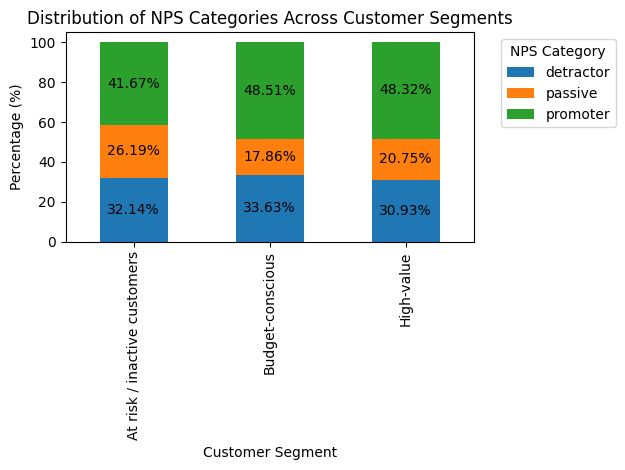

In [35]:
plt.figure(figsize=(8, 6))
ax = nps_segment_dist.plot(kind='bar', stacked=True)
plt.title('Distribution of NPS Categories Across Customer Segments')
plt.xlabel('Customer Segment')
plt.ylabel('Percentage (%)')
plt.legend(title='NPS Category', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    ax.annotate(f'{height:.2f}%', (x, y), ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

**Key insights:**

- **High-value** customers have the highest proportion of promoters, indicating strong brand loyalty and satisfaction. However, some customers may have unmet expectations or issues that need addressing.

- **Budget-conscious** customers have a relatively balanced distribution of promoters, passives, and detractors. The slightly higher proportion of promoters suggests moderate satisfaction, but a significant portion are detractors, indicating dissatisfaction.

- **At-risk/inactive** customers has the lowest share of promoters, suggesting disengagement and dissatisfaction, possibly due to irrelevant products or lack of engagement.

#### **Financial Health Across Customer Segments**

In [36]:
# Computing the correlation matrix for the selected variables to assess relationships between them
variables = ['log_balance', 'log_debt', 'log_income', 'debt_to_income', 'balance_to_debt']
correlation_matrix = df[variables].corr()
print(correlation_matrix)

                 log_balance  log_debt  log_income  debt_to_income  \
log_balance         1.000000 -0.025793    0.868033       -0.623901   
log_debt           -0.025793  1.000000    0.037600        0.732619   
log_income          0.868033  0.037600    1.000000       -0.644057   
debt_to_income     -0.623901  0.732619   -0.644057        1.000000   
balance_to_debt     0.990248 -0.137972    0.856608       -0.697219   

                 balance_to_debt  
log_balance             0.990248  
log_debt               -0.137972  
log_income              0.856608  
debt_to_income         -0.697219  
balance_to_debt         1.000000  


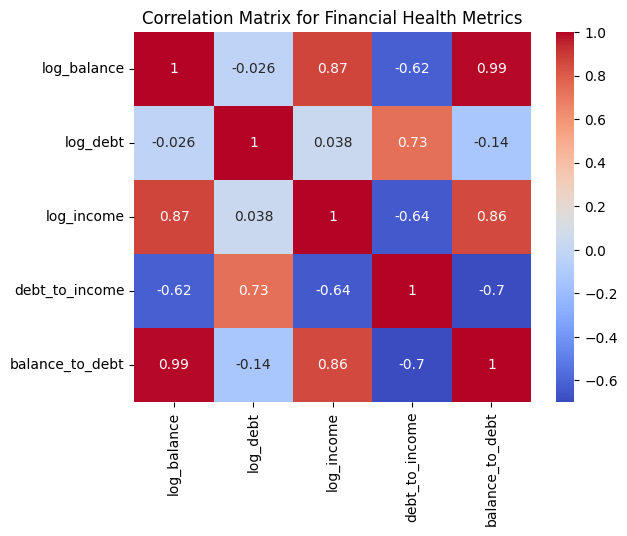

In [37]:
# Heatmap of correlation matrix for financial health metrics
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Financial Health Metrics')
plt.show()

**Key insights:**  

Higher income and savings (**log_income** and **log_balance**) strongly correlate with improved financial health metrics like **balance_to_debt**, while rising debt (**log_debt**) increases **debt_to_income** ratios. Notably, income growth and savings accumulation counteract debt burdens, suggesting that boosting income and reducing debt are critical for financial stability. The near-perfect correlation between **log_balance** and **balance_to_debt** underscores savings as a key lever for debt management.

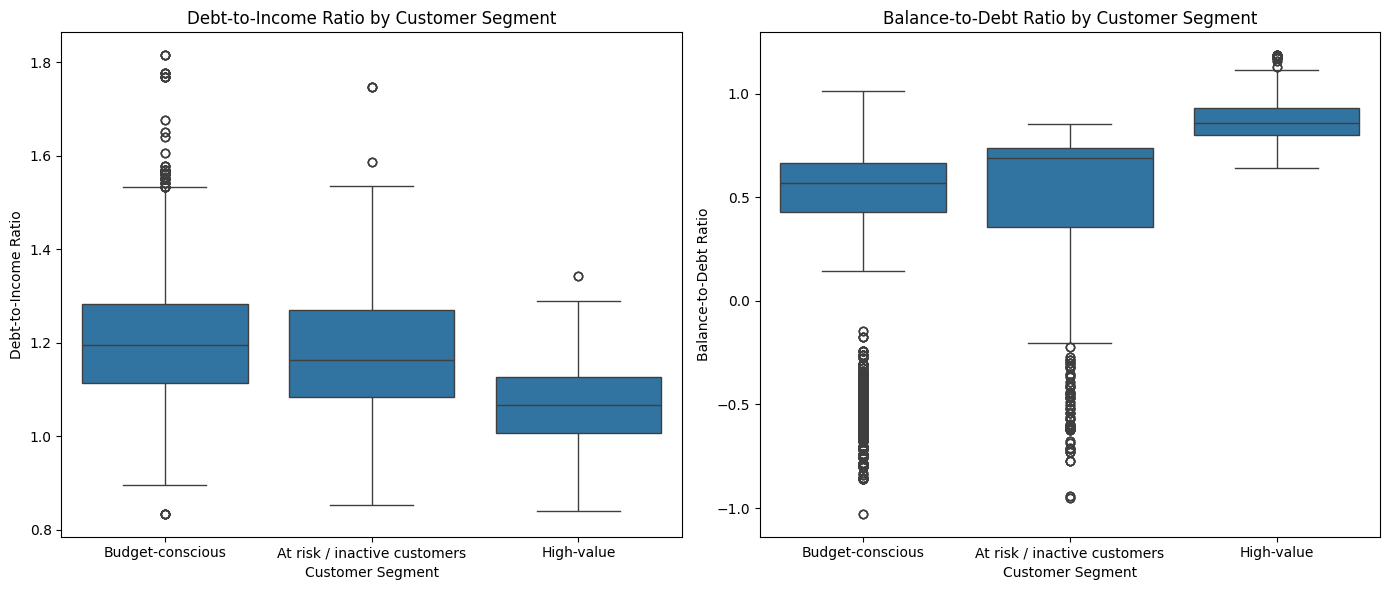

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot of 'debt-to-income' ratio by customer segment
sns.boxplot(x='Segment', y='debt_to_income', data=df, ax=ax[0])
ax[0].set_title('Debt-to-Income Ratio by Customer Segment')
ax[0].set_xlabel('Customer Segment')
ax[0].set_ylabel('Debt-to-Income Ratio')

# Boxplot of 'balance-to-debt' ratio by customer segment
sns.boxplot(x='Segment', y='balance_to_debt', data=df, ax=ax[1])
ax[1].set_title('Balance-to-Debt Ratio by Customer Segment')
ax[1].set_xlabel('Customer Segment')
ax[1].set_ylabel('Balance-to-Debt Ratio')

plt.tight_layout()
plt.show()

**Key insights:**

- **High-value** customers have a generally lower and more stable debt-to-income (DTI) ratio, indicating better financial management and lower reliance on debt. The positive balance-to-debt ratio with minimal variation suggests strong financial health and likely savings.

- **Budget-conscious** customers have a generally moderate DTI ratio with some extreme outliers, suggesting potential financial strain for a subset. The higher balance-to-debt ratio indicates relatively higher balances compared to their debt. However, many outliers show negative ratios, possibly indicating account overdrafts or defaults.

- **At-risk** customers show a broad variation of DTI ratio, with a few outliers and a median similar to budget-conscious customers, suggesting inconsistent financial stability within the group. There is a significant variation in balance-to-debt ratio, with a large proportion having negative ratios, signaling potential financial distress.

In [39]:
# Filtering data for customers with days_past_due = 0
on_time = df[df['days_past_due'] < 0]
print(on_time)

       customer_id                       Segment  age         job   marital  \
0              179              Budget-conscious   32     retired    single   
2              179              Budget-conscious   32     retired    single   
5               81  At risk / inactive customers   20  unemployed    single   
6               13              Budget-conscious   35     student    single   
7               13              Budget-conscious   35     student    single   
...            ...                           ...  ...         ...       ...   
12885         3407                    High-value   37     unknown    single   
12886         3407                    High-value   37     unknown    single   
12887         3407                    High-value   37     unknown    single   
12892         2660                    High-value   33     unknown  divorced   
12893         2660                    High-value   33     unknown  divorced   

       education  default   balance       debt    i

In [40]:
# Calculating the proportion of on-time payers in each segment
on_time_counts = on_time.groupby('Segment').size()
total_counts = df.groupby('Segment').size()
on_time_proportion = (on_time_counts / total_counts) * 100
print(on_time_proportion)

Segment
At risk / inactive customers    78.835979
Budget-conscious                79.758407
High-value                      82.943371
dtype: float64


C:\Users\Admin\AppData\Local\Temp\ipykernel_19040\72201967.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=on_time_proportion.index, y=on_time_proportion.values, palette='viridis')


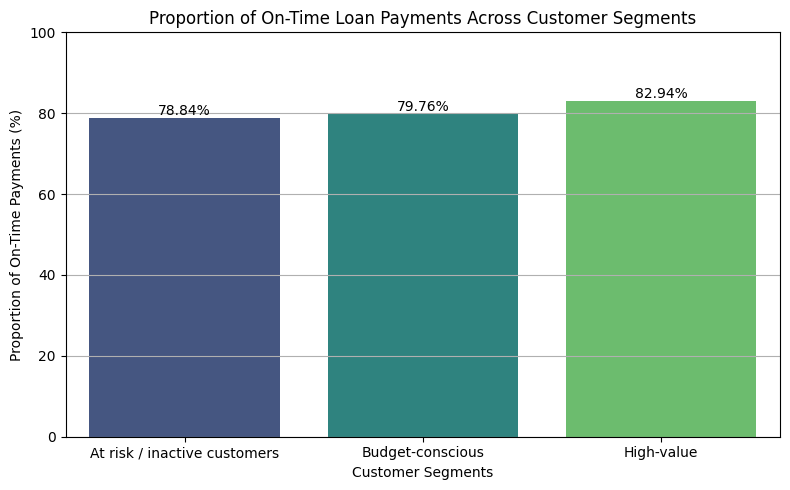

In [41]:
# Bar plot of the proportion of customers with on-time loan payments for each segment
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=on_time_proportion.index, y=on_time_proportion.values, palette='viridis')
plt.title('Proportion of On-Time Loan Payments Across Customer Segments')
plt.xlabel('Customer Segments')
plt.ylabel('Proportion of On-Time Payments (%)')
plt.ylim(0, 100)
plt.grid(axis='y')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                color='black', fontsize=10, 
                xytext=(0, 5), textcoords='offset points')  

plt.tight_layout()
plt.show()

**Key insights:**  

- **High-value** customers exhibit the highest on-time payment rate, indicating strong financial reliability and stability. This suggests they are ideal candidates for premium offers (e.g. lower interest rates, exclusive credit lines) to reinforce loyalty.

- **Budget-conscious** customers have the lowest on-time payment rate, likely due to cash flow sensitivity. They may benefit from flexible repayment plans, automated reminders, or budgeting tools to reduce late payments.

- **At-risk/inactive** customers show a moderate on-time payment rate, implying their "risk" may stem from inactivity (e.g. low engagement with other bank services) rather than payment defaults. Proactive re-engagement strategies (e.g. personalized incentives, reactivation campaigns) could improve retention.

In [42]:
# Calculating the percentage distribution of loan categories within each segment
loan_cat_percent = pd.crosstab(df['Segment'], df['loan_category'], normalize='index') * 100
print(loan_cat_percent)

loan_category                 Asset Acquisition  Business & Education  \
Segment                                                                 
At risk / inactive customers          10.582011              5.026455   
Budget-conscious                      14.560888              5.158341   
High-value                            13.326551              5.595117   

loan_category                 Credit Product  Debt Management  \
Segment                                                         
At risk / inactive customers       19.973545        53.306878   
Budget-conscious                   18.968332        50.429862   
High-value                         18.006104        51.135978   

loan_category                 Lifestyle & Personal  Miscellaneous  
Segment                                                            
At risk / inactive customers              4.894180       6.216931  
Budget-conscious                          3.504190       7.378387  
High-value                          

**Key Insights:**  

- **High-value customers** have the highest Asset Acquisition loans and the lowest Debt Management loans, indicating a focus on investments and aligning with their financial stability.

- **Budget-conscious** customers show high Debt Management loans, signaling potential financial stress or reliance on loans to manage existing obligations. Significant Credit Product usage suggests they may use credit to bridge cash flow gaps.

- **At-risk/inactive** customers have the highest Debt Management loans, indicating severe financial strain, which likely contributes to their "at-risk" status.

#### **Product Usage Across Customer Segments**

In [43]:
# Calculating the average product ownership for each segment across specified product columns
product_columns = ['has_investment_product', 'has_credit_card', 
                   'has_personal_loan', 'has_fixed_deposit', 'has_insurance']

usage_summary = df.groupby('Segment')[product_columns].mean()
print("Product Usage Proportions by Segment:")
print(usage_summary)

Product Usage Proportions by Segment:
                              has_investment_product  has_credit_card  \
Segment                                                                 
At risk / inactive customers                0.642857         0.702381   
Budget-conscious                            0.644793         0.667646   
High-value                                  0.650051         0.772126   

                              has_personal_loan  has_fixed_deposit  \
Segment                                                              
At risk / inactive customers           0.293651           0.710317   
Budget-conscious                       0.256938           0.637610   
High-value                             0.282808           0.681587   

                              has_insurance  
Segment                                      
At risk / inactive customers       0.420635  
Budget-conscious                   0.417891  
High-value                         0.523906  


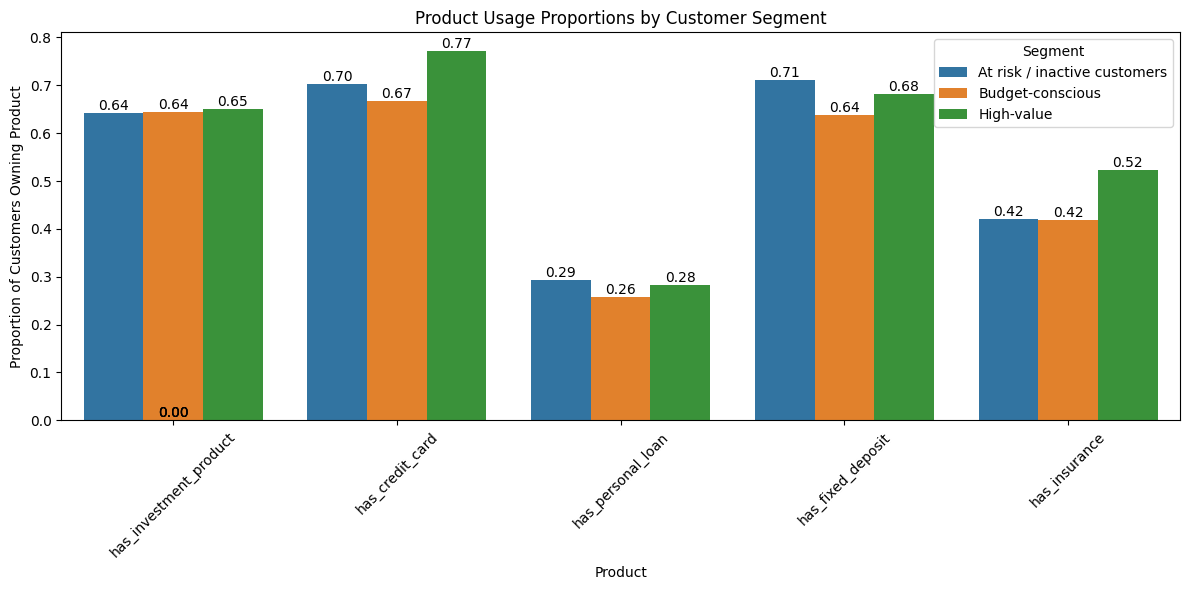

In [44]:
# Barplot of product usage proportions by customer segment
usage_summary_reset = usage_summary.reset_index()
usage_melted = usage_summary_reset.melt(id_vars='Segment', 
                                         var_name='Product', 
                                         value_name='Proportion')

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=usage_melted, x='Product', y='Proportion', hue='Segment')
plt.title('Product Usage Proportions by Customer Segment')
plt.ylabel('Proportion of Customers Owning Product')
plt.xlabel('Product')
plt.legend(title='Segment')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                color='black', fontsize=10, 
                xytext=(0, 5), textcoords='offset points')  

plt.tight_layout()
plt.show()

In [46]:
# Performing Chi-square test for statistical significance in product usage differences across segments
for product in product_columns:
    print(f"Chi-Square Test for {product}")
    
    ct = pd.crosstab(df['Segment'], df[product])
    print("Contingency Table:")
    print(ct)
    
    chi2, p, dof, expected = stats.chi2_contingency(ct)

    print(f"Chi-square Statistic: {chi2:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"p-value: {p:.4f}")
    print("Expected Frequencies:")
    print(expected)
    
    if p < 0.05:
        print("=> The difference in usage across segments is statistically significant.")
    else:
        print("=> The difference in usage across segments is not statistically significant.")

Chi-Square Test for has_investment_product
Contingency Table:
has_investment_product           0     1
Segment                                 
At risk / inactive customers   270   486
Budget-conscious              3264  5925
High-value                    1032  1917
Chi-square Statistic: 0.3020
Degrees of Freedom: 2
p-value: 0.8598
Expected Frequencies:
[[ 267.71335505  488.28664495]
 [3253.99208934 5935.00791066]
 [1044.29455561 1904.70544439]]
=> The difference in usage across segments is not statistically significant.
Chi-Square Test for has_credit_card
Contingency Table:
has_credit_card                  0     1
Segment                                 
At risk / inactive customers   225   531
Budget-conscious              3054  6135
High-value                     672  2277
Chi-square Statistic: 114.9622
Degrees of Freedom: 2
p-value: 0.0000
Expected Frequencies:
[[ 231.65472313  524.34527687]
 [2815.70800372 6373.29199628]
 [ 903.63727315 2045.36272685]]
=> The difference in usage a

**Summary of key findings:**

- **High-value** customers show dominance in premium products with the highest adoption of investment products, credit cards, fixed deposits, and insurance. Their financial stability is further reinforced by the low personal loan usage.

- **Budget-conscious** customers show moderate adoption of core products such as credit cards and insurance, but investment products lag behind high-value. There is also low fixed deposit usage, suggesting limited savings capacity.

- **At-risk/inactive** customers show high personal loan reliance and low engagement with premium products such as investment, credit cards, and insurance.

The chi-square tests validate that customer segments exhibit distinct financial behaviors, enabling highly targeted and data-driven marketing strategies.

#### **Transaction History Across Customer Segments**

In [47]:
# Calculating the count of transactions for each segment
tx_counts = df.groupby('Segment').size().reset_index(name='tx_count')
print(tx_counts)

# Calculating the count of transactions for each customer in each segment
customer_tx = df.groupby(['customer_id', 'Segment']).size().reset_index(name='tx_count')
print(customer_tx)

# Calculating the average transaction count per segment
avg_tx_count_by_segment = customer_tx.groupby('Segment')['tx_count'].mean().reset_index()
print(avg_tx_count_by_segment)

                        Segment  tx_count
0  At risk / inactive customers       756
1              Budget-conscious      9189
2                    High-value      2949
      customer_id                       Segment  tx_count
0               3  At risk / inactive customers         6
1               4              Budget-conscious         6
2               8              Budget-conscious         3
3              13              Budget-conscious         3
4              21              Budget-conscious         9
...           ...                           ...       ...
1240         3983              Budget-conscious         6
1241         3984              Budget-conscious         9
1242         3990                    High-value         6
1243         3996              Budget-conscious        21
1244         3997              Budget-conscious        12

[1245 rows x 3 columns]
                        Segment   tx_count
0  At risk / inactive customers   5.641791
1              Budget-con

In [48]:
# Calculating the distribution of transaction types across segments
tx_type_distribution = pd.crosstab(df['Segment'], df['transaction_type'])
print(tx_type_distribution)

# Calculating the percentage of each transaction type within each segment
tx_type_percent = pd.crosstab(df['Segment'], df['transaction_type'], normalize='index') * 100
print(tx_type_percent)

transaction_type              Credit  Deposit  Transfer  Withdrawal
Segment                                                            
At risk / inactive customers     213      198       165         180
Budget-conscious                2310     2205      2247        2427
High-value                       660      768       798         723
transaction_type                 Credit    Deposit   Transfer  Withdrawal
Segment                                                                  
At risk / inactive customers  28.174603  26.190476  21.825397   23.809524
Budget-conscious              25.138753  23.996082  24.453151   26.412014
High-value                    22.380468  26.042726  27.060020   24.516785


In [49]:
# Calculating the distribution of money flow across segments
flow_distribution = pd.crosstab(df['Segment'], df['money_flow'])
print(flow_distribution)

# Calculating the percentage of money flow within each segment
flow_percent = pd.crosstab(df['Segment'], df['money_flow'], normalize='index') * 100
print(flow_percent)

money_flow                    Money In  Money Out
Segment                                          
At risk / inactive customers       411        345
Budget-conscious                  4515       4674
High-value                        1428       1521
money_flow                     Money In  Money Out
Segment                                           
At risk / inactive customers  54.365079  45.634921
Budget-conscious              49.134835  50.865165
High-value                    48.423194  51.576806


C:\Users\Admin\AppData\Local\Temp\ipykernel_19040\2538517884.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_tx_count_by_segment, x='Segment', y='tx_count', palette='viridis', ax=ax[0])


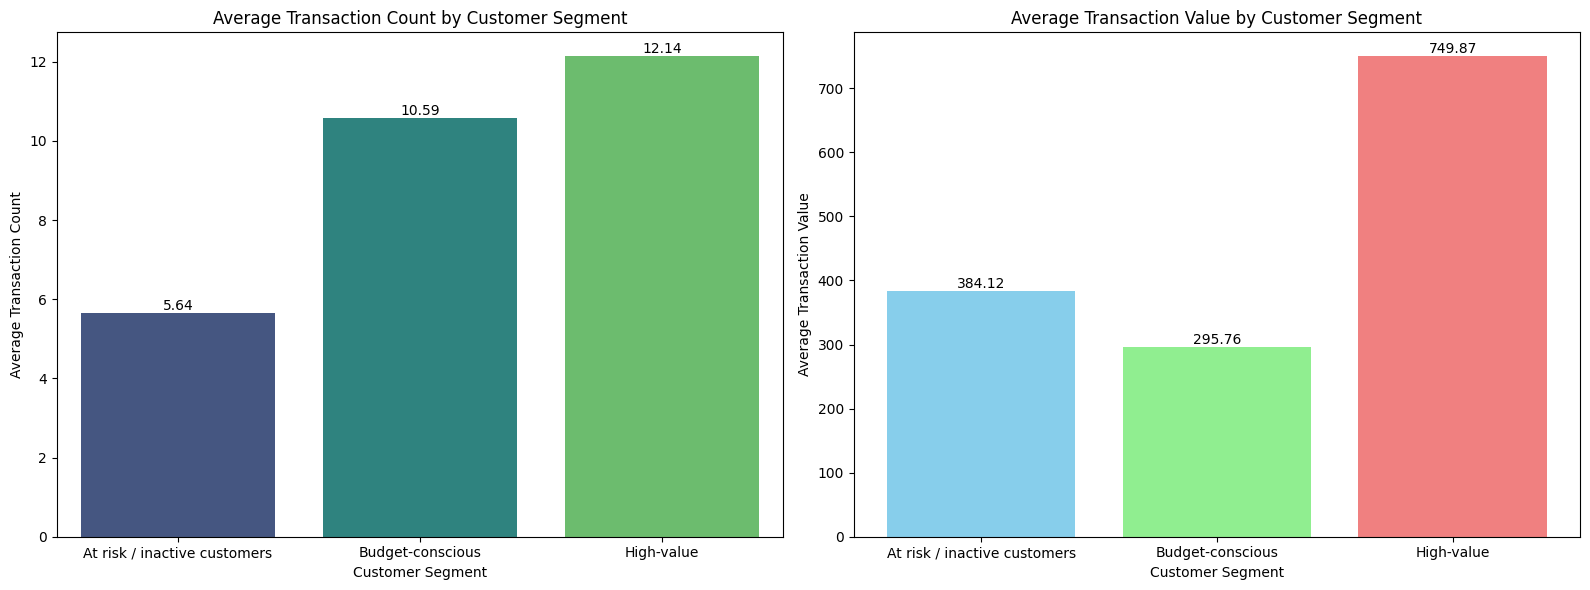

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Barplot of the average transaction count by customer segment
sns.barplot(data=avg_tx_count_by_segment, x='Segment', y='tx_count', palette='viridis', ax=ax[0])
ax[0].set_xlabel('Customer Segment')
ax[0].set_ylabel('Average Transaction Count')
ax[0].set_title('Average Transaction Count by Customer Segment')

for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height():.2f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   color='black', fontsize=10, 
                   xytext=(0, 5), textcoords='offset points') 

# Barplot of the average transaction value by customer segment
avg_transaction_value = df.groupby('Segment')['transaction_amt'].mean().reset_index()
bars = ax[1].bar(avg_transaction_value['Segment'], avg_transaction_value['transaction_amt'], 
                 color=['skyblue', 'lightgreen', 'lightcoral'])
ax[1].set_xlabel('Customer Segment')
ax[1].set_ylabel('Average Transaction Value')
ax[1].set_title('Average Transaction Value by Customer Segment')

for bar in bars:
    ax[1].text(bar.get_x() + bar.get_width() / 2, 
               bar.get_height(), 
               f'{bar.get_height():.2f}', 
               ha='center', 
               va='bottom', 
               fontsize=10, 
               color='black')

plt.tight_layout()
plt.show()

In [51]:
# Grouping by segment and money flow, and summing the transaction amount within each combination
money_summary = df.groupby(['Segment', 'money_flow'])['transaction_amt'].sum().reset_index()

# Calculating the percentage of each money flow type within each segment based on transaction amount
money_summary['percentage'] = money_summary.groupby('Segment')['transaction_amt'].transform(lambda x: x / x.sum() * 100)
print(money_summary)

# Transforming the money flow percentage data to a long format for easier comparison across segments
flow_percent.reset_index(inplace=True)
flow_percent_melted = flow_percent.melt(id_vars='Segment', var_name='money_flow', value_name='percentage')
print(flow_percent_melted)

                        Segment money_flow  transaction_amt  percentage
0  At risk / inactive customers   Money In        162020.34   55.792745
1  At risk / inactive customers  Money Out        128376.45   44.207255
2              Budget-conscious   Money In       1323412.47   48.694943
3              Budget-conscious  Money Out       1394349.12   51.305057
4                    High-value   Money In       1060850.43   47.972737
5                    High-value  Money Out       1150510.65   52.027263
                        Segment money_flow  percentage
0  At risk / inactive customers   Money In   54.365079
1              Budget-conscious   Money In   49.134835
2                    High-value   Money In   48.423194
3  At risk / inactive customers  Money Out   45.634921
4              Budget-conscious  Money Out   50.865165
5                    High-value  Money Out   51.576806


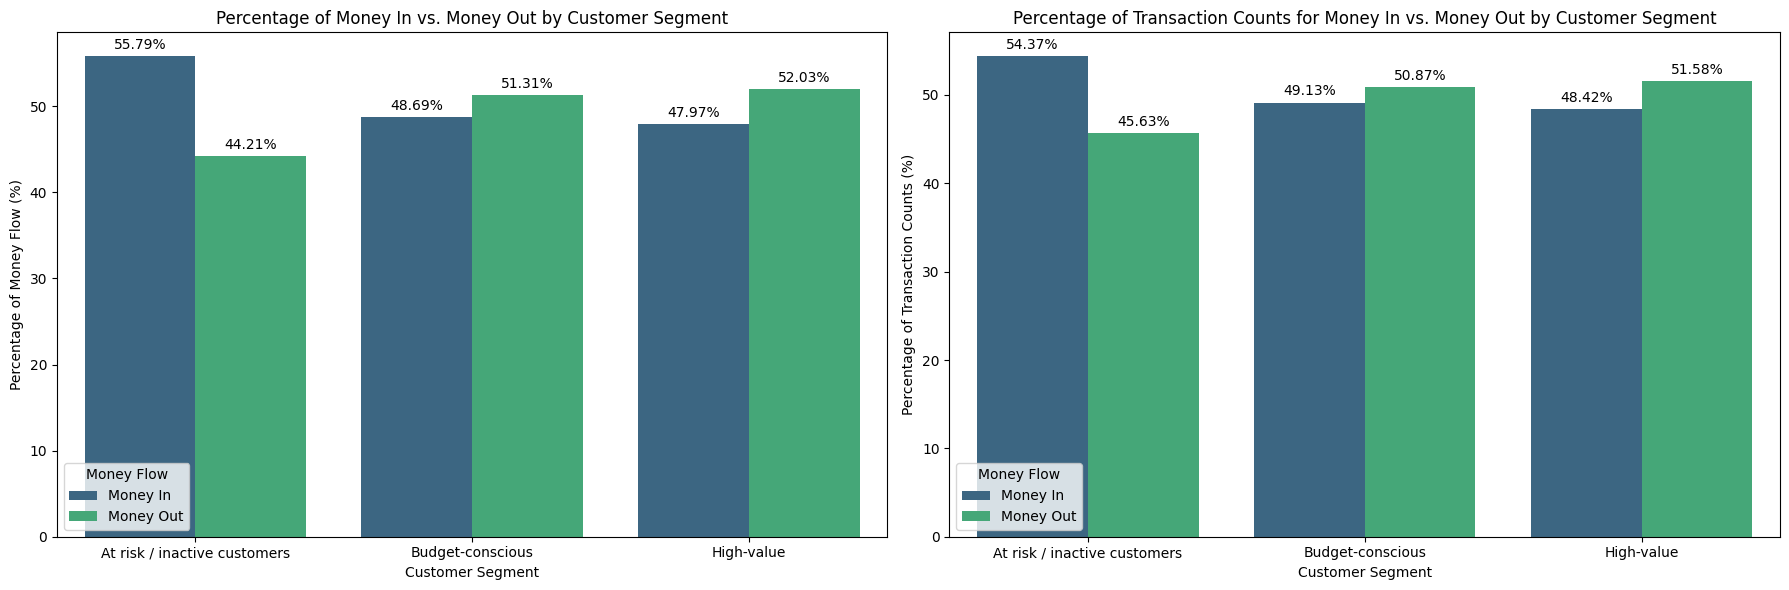

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Bar plot of the percentage of money in vs. money out by customer segment
sns.barplot(data=money_summary, x='Segment', y='percentage', hue='money_flow', palette='viridis', ax=ax[0])

for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.2f%%', padding=3)

ax[0].set_xlabel('Customer Segment')
ax[0].set_ylabel('Percentage of Money Flow (%)')
ax[0].set_title('Percentage of Money In vs. Money Out by Customer Segment')
ax[0].legend(title='Money Flow')

# Bar plot of the percentage of transaction counts for money in vs. money out by customer segment
sns.barplot(data=flow_percent_melted, x='Segment', y='percentage', hue='money_flow', palette='viridis', ax=ax[1])

for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.2f%%', padding=3)

ax[1].set_xlabel('Customer Segment')
ax[1].set_ylabel('Percentage of Transaction Counts (%)')
ax[1].set_title('Percentage of Transaction Counts for Money In vs. Money Out by Customer Segment')
ax[1].legend(title='Money Flow')

plt.tight_layout()
plt.show()

**Summary of key findings:**

- **High-value** customers lead in transaction frequency and value, indicating frequent and high-value financial activities (e.g. investments, large purchases). Combined with their net depositor status (strong cash inflow) and premium product dominance, this reflects wealth-building behavior.

- **Budget-conscious** customers show moderate transaction frequency and value, indicating cautious spending. This aligns with their slight net spender status (sligtly higher cash outflow) and reliance on core products.

- **At-risk** customers exhibit the lowest transaction frequency and value, indicating low engagement rate. They are also heavy net spenders (high cash outflow), which can indicate financial instabiliy.

#### **Digital Engagement Across Customer Segments**

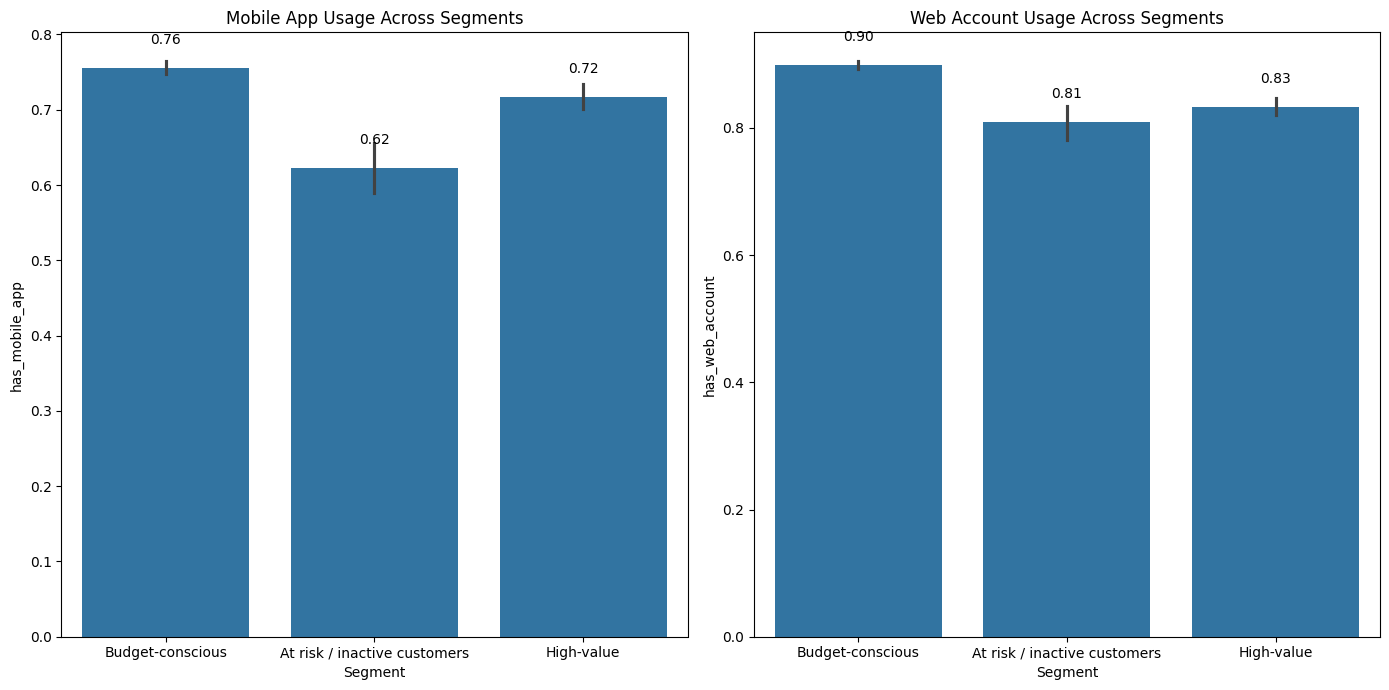

In [53]:
# Barplot of the engagement rate for each customer segment
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.barplot(x='Segment', y='has_mobile_app', data=df, ax=ax[0])
ax[0].set_title('Mobile App Usage Across Segments')

for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height():.2f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   color='black', fontsize=10, 
                   xytext=(0, 20), textcoords='offset points')

sns.barplot(x='Segment', y='has_web_account', data=df, ax=ax[1])
ax[1].set_title('Web Account Usage Across Segments')

for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height():.2f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   color='black', fontsize=10, 
                   xytext=(0, 20), textcoords='offset points')

plt.tight_layout()
plt.show()

In [54]:
# Grouping by segment and computing the most recent usage date for mobile and web
recency_metrics = df.groupby('Segment').agg({
    'last_mobile_use': 'max',
    'last_web_use': 'max'
})

print(recency_metrics)

                             last_mobile_use last_web_use
Segment                                                  
At risk / inactive customers      2024-11-30   2024-12-31
Budget-conscious                  2024-12-31   2024-12-31
High-value                        2024-12-21   2024-12-31


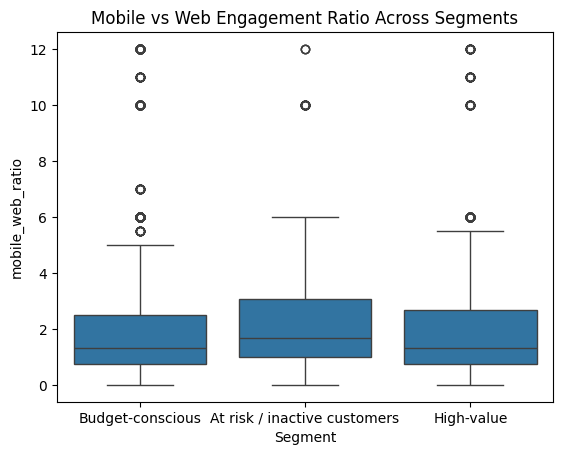

In [55]:
# Boxplot of mobile and web engagement ratio across customer segments
sns.boxplot(x='Segment', y='mobile_web_ratio', data=df)
plt.title('Mobile vs Web Engagement Ratio Across Segments')
plt.show()

In [56]:
# Identifying inactive users (those with no mobile or web logins)
inactive_users = df[(df['mobile_logins_wk'] == 0) & (df['web_logins_wk'] == 0)]
inactive_by_segment = inactive_users.groupby('Segment').size()
print(inactive_by_segment)

Segment
Budget-conscious    27
High-value           6
dtype: int64


**Summary of key insights:**  

- **High-value** customers have the highest mobile app adoption and mobile-web ratio, indicating a strong preference for mobile platforms. 

- **Budget-conscious** customers have moderate engagement but include inactive users requiring re-engagement. 

- **At-risk/inactive** customers have the lowest mobile app and web account usage, signaling limited digital interaction.

#### **Targeted Marketing Approaches for each Customer Segment**

##### **1. High-value Customers**

**Key Characteristics:**  
- **High Loyalty:** High percentage of promoters and on-time loan payments  
- **Strong Financial Health:** Lower debt-to-income ratios and high balance-to-debt ratios
- **Premium Product Behavior:** High adoption of investment products, fixed deposits, insurance, and credit cards 
- **Active Digital Engagement:** High mobile app adoption and high transaction values and frequency

**Targeted Marketing Approaches:**  
- **Retention & Loyalty Programmes:**  
  - Offer exclusive rewards, premium services, and personalized offers (e.g. tailored wealth management bundles, investment + insurance packages)
  - Develop loyalty initiatives that include benefits like cashback on large transactions and bonus interest rates on deposits

- **Upsell Premium Financial Services:**  
  - Promote wealth management services such as high-yield savings, portfolio diversification, and asset-backed loans
  - Leverage their digital engagement by offering advanced mobile app features (e.g. AI-driven insights, instant investment alerts)

- **Proactive Engagement:**  
  - Use personalized push notifications and tailored mobile alerts to highlight exclusive offers and upcoming premium products

#### **2. Budget-Conscious Customers**

**Key Characteristics:**  
- **Mixed Satisfaction:** Moderate number of promoters and detractors
- **Financial Constraints:** Moderate debt-to-income ratios with some outliers and higher instances of debt management usage
- **Core Product Reliance:** Frequent use of credit cards and insurance but lower engagement with savings products like fixed deposits
- **Cautious Transaction Behavior:** Fewer and lower-value transactions with a slight net spending profile  
- **Digital Challenges:** Moderate mobile adoption but highest observed inactivity among digital users

**Targeted Marketing Approaches:**  
- **Value-Driven Financial Solutions:**  
  - Introduce cost-effective value propositions like micro-investment platforms and low-entry fixed deposits to encourage savings
  - Roll out debt relief programmes, debt consolidation options, and refinancing offers to alleviate debt stress

- **Educational & Financial Wellness Programs:**  
  - Offer content and workshops on debt management, budgeting tools, and financial literacy 
  - Provide automated savings tools to help transition spending to saving

- **Digital Engagement Incentives:**  
  - Launch app onboarding campaigns with incentives (e.g. cash rewards for first login or bill-payment discounts)  
  - Simplify app user experience with guided tutorials and educational content that address everyday financial needs

#### **3. At-Risk/Inactive Customers**

**Key Characteristics:**  
- **High Dissatisfaction:** Lowest promoter scores and highest percentage of detractors, reflecting disengagement 
- **Financial Stress:** High debt management usage, significant negative balance-to-debt ratios, and inconsistent financial stability
- **Loan Dependence:** Higher reliance on personal loans and miscellaneous borrowing, indicating emergency-driven needs  
- **Frequent Low-Value Transactions:** High frequency of small transactions paired with a net spending pattern, suggesting cash flow issues
- **Digital Disengagement:** Lowest mobile adoption and overall lower digital interaction

**Targeted Marketing Approaches:**  
- **Reactivation & Outreach Campaigns:**  
  - Develop personalized re-engagement initiatives such as targeted emails, SMS reminders, and one-on-one consultations to understand their needs
  - Offer exclusive reactivation incentives like small, short-term loans or debt consolidation programs to rebuild trust

- **Tailored Debt & Financial Recovery Solutions:**  
  - Introduce debt restructuring, credit counseling, and hardship programms to address their acute financial challenges 
  - Provide low-risk digital products (e.g. secured credit cards, small fixed deposit options) to gently reintroduce them to the bank’s services

- **Simplify and Support Digital Adoption:**  
  - Run digital re-engagement campaigns with step-by-step guides for using mobile apps, along with perks such as fee waivers for app-based balance checks
  - Create a simplified, user-friendly digital interface to reduce friction and build confidence in digital banking

---

**Data-Driven Personalization:**  
Use customer data to continuously refine targeted messaging and product recommendations, ensuring that each campaign addresses the specific pain points and motivations of the segment.

**Feedback Loops:**  
Incorporate regular feedback mechanisms (e.g. surveys, digital engagement metrics) to monitor the impact of these targeted campaigns and adjust strategies as needed.